# Projet Techniques de Simulation

In [10]:
#imports 
import random as rd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.express as px
import threading
print("Dépendances importées")

Dépendances importées


## 1° Construction de nos objets

[Table de Walker] : 
|A-1 : 0.10|A-2 : 0.16|A-3 : 0.13|A-4 : 0.10|A-5 : 0.16|A-6 : 0.10|
|A-2 : 0.06|          |A-5 : 0.03|A-2 : 0.06|          |A-3 : 0.06|


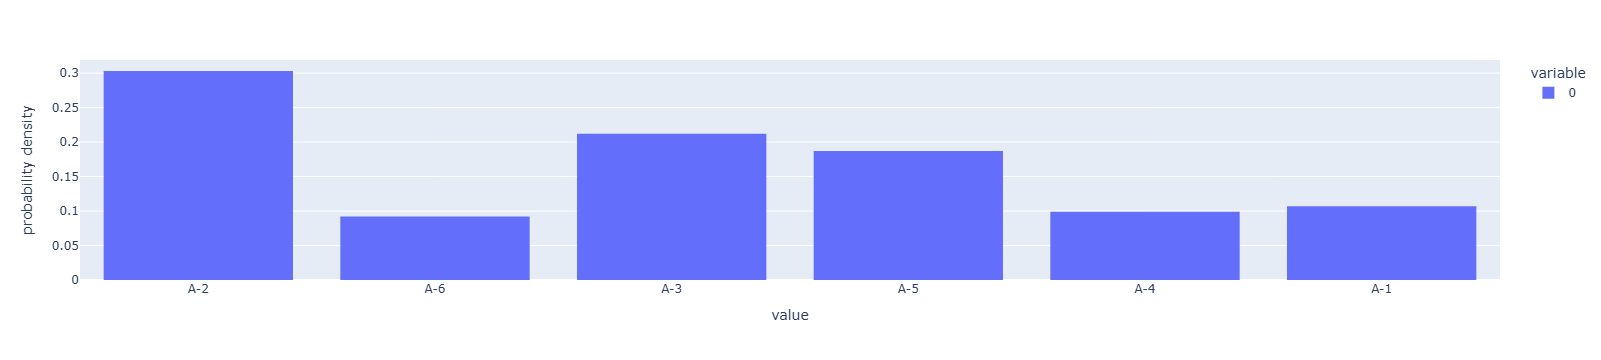

In [11]:
class walkerTable():
    def __init__(self, distribution : (float), distribution_values : tuple):
        """construction de la table de walker.
        Distribution est un tuple qui contient notre distribution de probablité.
        Distribution_values est un tuple qui contient les valeurs associées a notre distribution de probablité."""

        assert len(distribution) == len(distribution_values), "Tuples de tailles differentes. \n" + str(len(distribution)) + "x" + str(len(distribution_values)) #verification d'usage. Il doit y avoir autant de valeurs que le cardinal de notre distribution.
        self.distribution_values = distribution_values
        self.distribution = distribution
        self.n = len(self.distribution)
        #dictionnaire de distributions. 
        self.dt_01 = dict(zip([i for i in range(self.n)],
                             [
                                 [self.distribution_values[k],
                              self.distribution[k]] for k in range(self.n)]
                             )
                         )
        #dictionnaire des distributions compilées.
        self.dt_02 = dict(zip([i for i in range(self.n)],
                             [
                                 [] for k in range(self.n)]
                             )
                         )
        H = [] #Cela doit etre une liste temporaire. Liste des distribution superieures a la moyenne.
        L = [] #Cela doit etre une liste temporaire. Liste des distribution inferieures a la moyenne.
        for k in range(self.n):
            var = self.distribution[k]*self.n
            if var < 1:
                L.append(k)
            elif var > 1:
                H.append(k)
        #Listes H et L remplies.
        while (H != []) and (L != []):
            up = H[0] #indice de la premiere distribution superieure a la moyenne.
            low = L[0] #indice de la premiere distribution superieure a la moyenne.
            self.dt_01[up][1] = self.dt_01[up][1] - (1/self.n - self.dt_01[low][1])
            self.dt_02[low].append(self.dt_01[up][0]) #on rajoute la valeur de la distribution compilée
            self.dt_02[low].append((1/self.n - self.dt_01[low][1])) #on rajoute sa probabilité
            L.pop(0) #La sortie de low de la liste L est certaine, mais celle de up ne l'est pas.
            if (self.dt_01[up][1]*self.n < 1):
                L.append(up)
                H.pop(0)
            elif (self.dt_01[up][1]*self.n == 1):
                H.pop(0)
            pass
    def __repr__(self):
        return "[Table de Walker] : \n" + "|" + "|".join([elt[0] + " : " + str(elt[1] + 0.0000000001)[:4] for elt in self.dt_01.values()]) + "|" + "\n" + "|" + "|".join([self.dt_02[key][0] + " : " + str(self.dt_02[key][1] + 0.0000000001)[:4] if self.dt_02[key] != [] else " "*(7 + len(self.dt_01[key][0])) for key in self.dt_02.keys()]) + "|" 
    def __str__(self):
        return "[Table de Walker] : \n" + "|" + "|".join([elt[0] + " : " + str(elt[1] + 0.0000000001)[:4] for elt in self.dt_01.values()]) + "|" + "\n" + "|" + "|".join([self.dt_02[key][0] + " : " + str(self.dt_02[key][1] + 0.0000000001)[:4] if self.dt_02[key] != [] else " "*(7 + len(self.dt_01[key][0])) for key in self.dt_02.keys()]) + "|"
    def run(self):
        """Simulation de la distribution de probabilité a support fini"""
        U = rd.random() #Loi uniforme sur [0,1]
        var = int(U*self.n) #Partie entiere d'une loi uniforme sur [|0,n-1|]
        #Loi de bernoulli
        if (self.dt_02[var] == []) or ((U*self.n - var) <= self.dt_01[var][1]*self.n):
            return self.dt_01[var][0]
        else:
            return self.dt_02[var][0]
    def empiricLikelihood(self, n=1000):
        """Affiche l'histogramme de notre distribution pour n simmulation"""
        assert n != 0, "distribution non spécifiée"
        fig = px.histogram([self.run() for k in range(n)], histnorm='probability density')
        fig.show()
test = walkerTable((0.1,0.3,0.2,0.1,0.2,0.1),("A-1","A-2","A-3","A-4","A-5","A-6"))
print(test)
test.empiricLikelihood()

current state : A
|| 0.82 | 0.00 | 0.04 | 0.12 ||
|| 0.79 | 0.04 | 0.04 | 0.11 ||
|| 0.37 | 0.34 | 0.04 | 0.23 ||
|| 0.22 | 0.09 | 0.62 | 0.05 ||



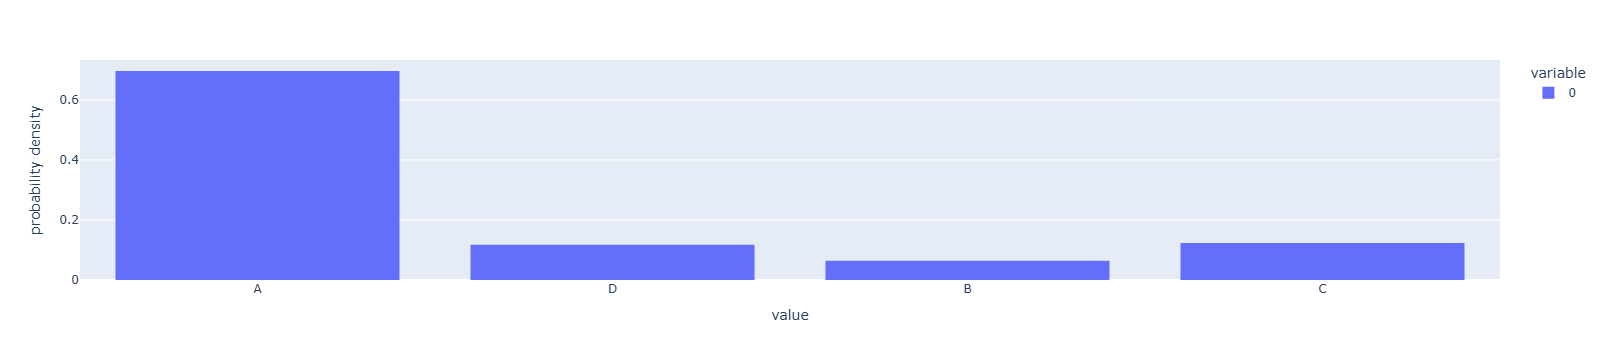

In [12]:
def get_a_random_distribution(n : int):
    """genere une distribution de probabilité a support fini."""
    substrat=[]
    for k in range(n):
        if (k==n-1) and (substrat!=[]):
            substrat.append(1-sum(substrat))
        else:
            substrat.append(np.random.uniform(0,1-sum(substrat)))
    return substrat
class Chaine_Markovienne():
    def __init__(self, states : tuple, mu_zero : (float), transitions : [[float]]):
        """Chaine_Markovienne modélise une chaine de markov a support fini.
        States est un tuple contenant tous les etats de la chaine.
        mu_zero (un tuple) est la distribution a support fini de la loi de X0.
        transitions la matrice de transition."""
        assert len(states) !=0, "Chaine sans états"
        self.states = states
        self.mu_zero = walkerTable(distribution=mu_zero,distribution_values=self.states)
        self.state = self.mu_zero.run()
        self.round = 0
        self.transitions = transitions
        self.transitions_walker_table = [walkerTable(distribution=line,distribution_values=self.states) for line in self.transitions]
        pass
    def run(self, rounds : int):
        """Simule la trajectoire d'une chaine de markov avec un temps d'arret discret T = rounds"""
        for i in range(rounds):
            self.state = self.transitions_walker_table[self.states.index(self.state)].run()   #!!!!!!! possibilité d'amélioration, l'index est couteux!!!!
            self.round = self.round + 1
        return self.state
    def __repr__(self):
        txt = "\n"
        for k in self.transitions:
            txt = txt + "||"
            for i in range(len(k)):
                txt = txt + " " + str(k[i] + 0.0000000001)[:4] + " |"
            txt = txt + "|\n"
        return "current state : " + str(self.state) + txt
    def __str__(self):
        txt = "\n"
        for k in self.transitions:
            txt = txt + "||"
            for i in range(len(k)):
                txt = txt + " " + str(k[i] + 0.0000000001)[:4] + " |"
            txt = txt + "|\n"
        return "current state : " + str(self.state) + txt
    def reinit(self):
        self.state = self.mu_zero.run()
        self.round = 0
        pass
    def empiricLikelihood(self, n=1000):
        """Affiche l'histogramme de notre distribution pour n simmulation"""
        assert n != 0, "distribution non spécifiée"
        fig = px.histogram([self.run(rounds=1000) for k in range(n)], histnorm='probability density')
        fig.show()
test1 = Chaine_Markovienne(states=("A","B","C","D"),
                         mu_zero=get_a_random_distribution(4),
                         transitions=[get_a_random_distribution(4) for i in range(4)])
print(test1)
test1.empiricLikelihood()

In [15]:
class Settings():
    def __init__(self, x_0=np.random.uniform(0,1), b=np.random.uniform(0.1,1), sigma=np.random.uniform(0.1,1), delta=np.random.uniform(0.1,1), a=np.random.uniform(0.1,1), alpha=np.random.uniform(1,10), u=np.random.uniform(100,200), c=np.random.uniform(0.1,1), N=rd.randint(1,10000), monte_carlo_limit=10000, lambda_01=np.random.uniform(0.1,1), lambda_02=np.random.uniform(0.1,1), lambda_03=np.random.uniform(0.1,1)):
        """
        Contient toutes les variables initiales de nos modeles
        """
        self.colors = {"bg" : 0}
        self.parameters = {"x 0" : x_0,
                          "b" : b,
                          "sigma" : sigma,
                          "delta" : delta,
                          "a" : a,
                          "alpha" : alpha,
                          "u" : u,
                          "c" : c,
                          "N" : N,
                          "limite machine de monte carlo limit" : monte_carlo_limit,
                          "lambda 01" : lambda_01,
                          "lambda 02" : lambda_02,
                          "lambda 03" : lambda_03}
    def __repr__(self):
        return "Parametres du modèle : " + "\n" + "\n".join([" - " + str(elt) + " : " + str(self.parameters[elt]) for elt in self.parameters.keys()])
    def __str__(self):
        return "Parametres du modèle : " + "\n" + "\n".join([" - " + str(elt) + " : " + str(self.parameters[elt]) for elt in self.parameters.keys()])
test = Settings()
test

Parametres du modèle : 
 - x 0 : 0.8455703840040079
 - b : 0.7741177733707815
 - sigma : 0.657138518916073
 - delta : 0.918636322878143
 - a : 0.6251121740139959
 - alpha : 6.7600834838496455
 - u : 100.65125848839597
 - c : 0.410437620464992
 - N : 9853
 - limite machine de monte carlo limit : 10000
 - lambda 01 : 0.6370310463685117
 - lambda 02 : 0.5457057537356044
 - lambda 03 : 0.9541662913290133

In [ ]:
class Modele_A(Chaine_Markovienne):
    def __init__(self, settings=Settings()):
        """
        Initialisation du modele A
        """
        random_mu_zero = [0]*3
        random_mu_zero[rd.randint(0,2)] = 1 #Car mu_zero est sensée etre déterministe
        self.settings = settings
        super().__init__(states=(settings.parameters["lambda 01"],
                                 settings.parameters["lambda 02"],
                                 settings.parameters["lambda 03"]),
                        mu_zero=random_mu_zero,
                        transitions=[get_a_random_distribution(3) for i in range(3)]) #constructeur de la classe mere
        self.T, self.X = [], [] #contenant respectivement les temps d'occurence de nos sinistres et les montants 
        pass
    def run_loi_de_puissance(self):
        return self.settings.parameters["a"]*(1 - rd.random())**(1/(1-self.settings.parameters["alpha"]))
    def run(self, rounds=365):
        #Surcouche de code, réécriture de la methode run

---
## 2° Modélisation

---

$(H_k)_{k \in N}$, une *chaine de markov*, possédant les attributs suivants : 

 - *ensemble d'états* $E = \{ 1, 2, 3 \}$

 - *loi initiale* $\mu_0$, une permutaion quelconque de $(1,0,0)$

 - de *matrice(stochastique) de transition * $Q \in M_3(R)$ :

$$
\begin{bmatrix}
p_{1,1} & p_{1,2} & p_{1,3}\\
p_{2,1} & p_{2,2} & p_{2,3}\\
p_{3,1} & p_{3,2} & p_{3,3}
\end{bmatrix}
$$

---


$$
	\lambda : 
	\begin{cases}
		[|1,3|] \to R_{+}^{*}\\
		t \longmapsto \lambda_t
	\end{cases}
	.
$$

$\lambda$, caractérisant les valeurs $(\lambda_1, \lambda_2, \lambda_3)$ associées aux valeurs respectives $(1,2,3)$ de la *chaine de markov* $(H_k)_{k \in N}$

---

Posons : $$ \forall t \in \mathbb{R}, \Delta^{*}(t) = N 1_{[0,365]}(t) \epsilon_{H_{\lfloor t \rfloor}}$$

$$\forall t \in [0,365]$$ $$ \mu^{*}(t) = \int_{0}^{t} \Delta^{*}(x)dx  $$

Soit $(T_t)_{t \in R_{+}^{*}}$, un processus de poisson in-homogène mélange ***d'intensité*** : $\Delta^{*}$ 

In [ ]:
class Modele_B():
    #Faire du modele B, une classe fille de la chaine de Markov n'est pas une idée interessante, car les assurés ne partagent pas de météo commune.
    #La parallélisation des calculs sera nécéssairement plus importante ici que pour le modele A
    def __init__(self, settings=Settings()):
        self.settings = settings
        pass